In [1]:
!pip install np_utils

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install spectral

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install keras
!pip install tensorflow
!pip install jupyter-tensorboard
!pip install scikit-learn
!pip install plotly
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
#os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

from array import array

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral
import math
import pickle
import tensorboard

init_notebook_mode(connected=True)
%matplotlib inline

# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)
# !rm -r sample_data


2024-05-22 16:14:40.977278: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 16:14:41.053615: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 16:14:42.231830: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
# if not (os.path.isfile('Indian_pines_corrected.mat')):
#   !wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
# if not (os.path.isfile('Indian_pines_gt.mat')):
#   !wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

#if not (os.path.isfile('/content/Salinas_corrected.mat')):
#  !wget https://github.com/gokriznastic/HybridSN/raw/master/data/Salinas_corrected.mat
#if not (os.path.isfile('/content/Salinas_gt.mat')):
#  !wget https://github.com/gokriznastic/HybridSN/raw/master/data/Salinas_gt.mat

# Data Loading

In [6]:
## GLOBAL VARIABLES
dataset = 'PU'
#test_ratio = 0.7
testRatio=0.15
validationRatio=0.15
windowSize = 25

In [7]:
def loadData(name):
    data_path = '../Pavia University/'

    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']

    return data, labels


In [8]:
from sklearn.model_selection import train_test_split
testRatio=0.15
validationRatio=0.15
def splitTrainTestValidationSet(X, y, testRatio, validationRatio, randomState=345):
    # Calculate the proportion of the validation set out of the total dataset
    validation_size = validationRatio / (1 - testRatio)
    
    # Split the dataset into a temporary training set and a testing + validation set
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(testRatio + validationRatio), random_state=randomState,
                                                      stratify=y)
    
    # Split the temporary dataset into the actual testing set and the validation set
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=validation_size, random_state=randomState,
                                                      stratify=y_temp)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [9]:
#def splitTrainTestSet(X, y, testRatio, randomState=345):
#    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
#                                                        stratify=y)
#    return X_train, X_test, y_train, y_test

In [10]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [11]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [12]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [13]:
X, y = loadData(dataset)

X.shape, y.shape

((610, 340, 103), (610, 340))

In [14]:
K = X.shape[2]

In [15]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(610, 340, 15)

In [16]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((42776, 25, 25, 15), (42776,))

In [17]:
Xtrain, Xval, Xtest, ytrain, yval, ytest = splitTrainTestValidationSet(X, y, testRatio,validationRatio)

Xtrain.shape, Xval.shape, Xtest.shape, ytrain.shape, yval.shape, ytest.shape

((29943, 25, 25, 15),
 (10568, 25, 25, 15),
 (2265, 25, 25, 15),
 (29943,),
 (10568,),
 (2265,))

Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

# Model and Training

In [18]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xval = Xval.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape, Xval.shape

((29943, 25, 25, 15, 1), (10568, 25, 25, 15, 1))

In [19]:
ytrain = keras.utils.to_categorical(ytrain)
yval = keras.utils.to_categorical(yval)

ytrain.shape, yval.shape

((29943, 9), (10568, 9))

Xvalid = Xvalid.reshape(-1, windowSize, windowSize, K, 1)
Xvalid.shape

yvalid = np_utils.to_categorical(yvalid)
yvalid.shape

In [20]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [21]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
#print(conv_layer3._keras_shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

2024-05-22 16:15:20.173371: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [22]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [23]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 25, 25, 15, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 23, 23, 9, 8)   │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 21, 21, 5, 16)  │         5,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 19, 19, 3, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 19, 19, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 17, 17, 64)     │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,735,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,844,793 (18.48 MB)

 Trainable params: 4,844,793 (18.48 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [25]:
# compiling the model
adam = Adam(learning_rate=0.000001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning:

Argument `decay` is no longer supported and will be ignored.



In [26]:
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

def step_decay(epoch):
   initial_lrate = 0.01
   drop = 0.10
   epochs_drop = 30.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(step_decay(len(self.losses)))
loss_history=LossHistory()

In [27]:
# checkpoint
filepath = "best-model150e-PU.keras"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,loss_history]

In [28]:
%reload_ext tensorboard
%tensorboard --logdir logs

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [29]:
#history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=150, callbacks=callbacks_list, validation_data=(Xval,yval))

In [30]:
#model.save("best-model.keras")

In [31]:
def show_final_history(history):
    
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    
    ax[0].plot(history.history['loss'], 'r-', label='Training Loss')
    ax[0].plot(history.history['val_loss'], 'g-', label='Validation Loss')
    ax[1].plot(history.history['accuracy'], 'r-', label='Training Accuracy')
    ax[1].plot(history.history['val_accuracy'], 'g-', label='Validation Accuracy')
    
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    
    plt.show();
    pass

In [32]:
#show_final_history(history)

# Validation

In [33]:
# load best weights
model.load_weights("best-model150e-PU.keras")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 



In [34]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(2265, 25, 25, 15, 1)

In [35]:
ytest = keras.utils.to_categorical(ytest)
ytest.shape

(2265, 9)

In [36]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       351
           1       1.00      1.00      1.00       988
           2       0.99      0.98      0.99       111
           3       0.99      0.98      0.99       162
           4       1.00      1.00      1.00        71
           5       1.00      1.00      1.00       266
           6       0.95      1.00      0.97        71
           7       0.98      0.99      0.99       195
           8       1.00      0.92      0.96        50

    accuracy                           0.99      2265
   macro avg       0.99      0.99      0.99      2265
weighted avg       0.99      0.99      0.99      2265



In [37]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [38]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100

    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [39]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

#with open(file_name, 'w') as x_file:
#    x_file.write('{} Test loss (%)'.format(Test_loss))
#    x_file.write('\n')
#    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
#    x_file.write('\n')
#    x_file.write('\n')
#    x_file.write('{} Kappa accuracy (%)'.format(kappa))
#    x_file.write('\n')
#    x_file.write('{} Overall accuracy (%)'.format(oa))
#    x_file.write('\n')
#    x_file.write('{} Average accuracy (%)'.format(aa))
#    x_file.write('\n')
#    x_file.write('\n')
#    x_file.write('{}'.format(classification))
#    x_file.write('\n')
#    x_file.write('{}'.format(confusion))

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9950 - loss: 0.0179


# Pure Pixels

In [40]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

In [41]:
# load the original image
X, y = loadData(dataset)

In [42]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [43]:
X,pca = applyPCA(X, numComponents=numComponents)

In [44]:
X = padWithZeros(X, PATCH_SIZE//2)

In [45]:
# # calculate the predicted image
# outputs = np.zeros((height,width))
# for i in range(height):
#     for j in range(width):
#         target = int(y[i,j])
#         if target == 0 :
#             continue
#         else :
#             image_patch=Patch(X,i,j)
#             X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
#             prediction = (model.predict(X_test_image))
#             prediction = np.argmax(prediction, axis=1)
#             outputs[i][j] = prediction+1

In [46]:
original_X, original_Y=loadData(dataset)

In [47]:
original_X.shape

(610, 340, 103)

In [ ]:
import sys
import os
import numpy as np

# Redirect stdout to /dev/null to suppress the output
sys.stdout = open(os.devnull, 'w')

# calculate the predicted image
outputs = np.zeros((height, width))
pure_pixels = {}

for i in range(height):
    for j in range(width):
        target = int(y[i, j])
        if target == 0:
            continue
        else:
            image_patch = Patch(X, i, j)
            X_test_img = image_patch.reshape(1, image_patch.shape[0], image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            
            # Predictions
            prediction = model.predict(X_test_img)[0]
            predicted_class = np.argmax(prediction)
            outputs[i][j] = predicted_class + 1

            # If the pixel is classified as a valid class
            if predicted_class >= 0:
                # Get the probability of the current pixel belonging to its predicted class
                prediction_probability = prediction[predicted_class]
                
                # If the class is not already in the dictionary or the probability is higher than the existing one
                if predicted_class not in pure_pixels or prediction_probability > pure_pixels[predicted_class]['probability']:
                    # Update the dictionary with the new pure pixel information
                    pure_pixels[predicted_class] = {'probability': prediction_probability, 'coordinates': (i, j)}

# Reset stdout back to normal
sys.stdout = sys.__stdout__

The pickle file is empty or does not exist.
{0: {0: 1233, 3: 704, 7: 1304, 6: 848, 1: 708, 4: 3960, 8: 637, 2: 1403, 5: 1465}, 1: {0: 1151, 3: 535, 7: 1446, 6: 980, 1: 274, 4: 3888, 8: 520, 2: 1507, 5: 1262}, 2: {0: 1216, 3: 552, 7: 1440, 6: 1168, 1: 239, 4: 3903, 8: 561, 2: 1341, 5: 1341}, 3: {0: 1238, 3: 508, 7: 1429, 6: 1038, 1: 419, 4: 4213, 8: 527, 2: 1379, 5: 1405}, 4: {0: 1151, 3: 459, 7: 1407, 6: 952, 1: 510, 4: 4544, 8: 373, 2: 1473, 5: 1502}, 5: {0: 1018, 3: 370, 7: 1431, 6: 947, 1: 558, 4: 4784, 8: 250, 2: 1461, 5: 1527}, 6: {0: 975, 3: 404, 7: 1464, 6: 968, 1: 517, 4: 5085, 8: 207, 2: 1459, 5: 1560}, 7: {0: 1005, 3: 424, 7: 1414, 6: 1042, 1: 470, 4: 5264, 8: 254, 2: 1450, 5: 1562}, 8: {0: 1024, 3: 391, 7: 1378, 6: 1106, 1: 425, 4: 5409, 8: 297, 2: 1423, 5: 1533}, 9: {0: 1090, 3: 347, 7: 1449, 6: 1172, 1: 423, 4: 5640, 8: 344, 2: 1442, 5: 1545}, 10: {0: 1162, 3: 333, 7: 1502, 6: 1199, 1: 509, 4: 5863, 8: 340, 2: 1476, 5: 1540}, 11: {0: 1158, 3: 272, 7: 1479, 6: 1197, 1: 566,

In [39]:
 pure_pixels

NameError: name 'pure_pixels' is not defined

In [44]:
#PP_pickle_file_path='pure_pixels.pkl'
#with open(PP_pickle_file_path, 'wb') as pickle_file:
#    pickle.dump(pure_pixels, pickle_file)

In [48]:
PP_pickle_file_path='pure_pixels.pkl'
with open(PP_pickle_file_path, 'rb') as pickle_file:
    pure_pixels_dictionary = pickle.load(pickle_file)

# Extract spectral information at pure pixel locations
spectral_information = {}
for band in range(original_X.shape[2]):  # Loop over each band
    spectral_information[band] = {}  # Initialize dictionary for each band
    for label, data in pure_pixels_dictionary.items():  # Loop over each pure pixel
        row, col = data['coordinates']
        spectral_information[band][label] = original_X[row, col, band]

# Print or use the spectral information
print(spectral_information)

{0: {0: 1233, 3: 704, 7: 1304, 6: 848, 1: 708, 4: 3960, 8: 637, 2: 1403, 5: 1465}, 1: {0: 1151, 3: 535, 7: 1446, 6: 980, 1: 274, 4: 3888, 8: 520, 2: 1507, 5: 1262}, 2: {0: 1216, 3: 552, 7: 1440, 6: 1168, 1: 239, 4: 3903, 8: 561, 2: 1341, 5: 1341}, 3: {0: 1238, 3: 508, 7: 1429, 6: 1038, 1: 419, 4: 4213, 8: 527, 2: 1379, 5: 1405}, 4: {0: 1151, 3: 459, 7: 1407, 6: 952, 1: 510, 4: 4544, 8: 373, 2: 1473, 5: 1502}, 5: {0: 1018, 3: 370, 7: 1431, 6: 947, 1: 558, 4: 4784, 8: 250, 2: 1461, 5: 1527}, 6: {0: 975, 3: 404, 7: 1464, 6: 968, 1: 517, 4: 5085, 8: 207, 2: 1459, 5: 1560}, 7: {0: 1005, 3: 424, 7: 1414, 6: 1042, 1: 470, 4: 5264, 8: 254, 2: 1450, 5: 1562}, 8: {0: 1024, 3: 391, 7: 1378, 6: 1106, 1: 425, 4: 5409, 8: 297, 2: 1423, 5: 1533}, 9: {0: 1090, 3: 347, 7: 1449, 6: 1172, 1: 423, 4: 5640, 8: 344, 2: 1442, 5: 1545}, 10: {0: 1162, 3: 333, 7: 1502, 6: 1199, 1: 509, 4: 5863, 8: 340, 2: 1476, 5: 1540}, 11: {0: 1158, 3: 272, 7: 1479, 6: 1197, 1: 566, 4: 5908, 8: 320, 2: 1483, 5: 1565}, 12: {0:

In [50]:
#spectral_pickle_file_path='spectral_information.pkl'
#with open(spectral_pickle_file_path, 'wb') as pickle_file:
#    pickle.dump(spectral_information, pickle_file)

In [49]:
# Given dictionary


# Initialize a 2D array with zeros
rows = 103
columns = 9
array = [[0] * columns for _ in range(rows)]

# Fill in the array with values from the dictionary
for row in range(rows):
    if row in spectral_information:
        for col, value in spectral_information[row].items():
            array[row][col] = value

# Printing the array
for row in array:
    print(row)
A_matrixPU_information=array

[1233, 708, 1403, 704, 3960, 1465, 848, 1304, 637]
[1151, 274, 1507, 535, 3888, 1262, 980, 1446, 520]
[1216, 239, 1341, 552, 3903, 1341, 1168, 1440, 561]
[1238, 419, 1379, 508, 4213, 1405, 1038, 1429, 527]
[1151, 510, 1473, 459, 4544, 1502, 952, 1407, 373]
[1018, 558, 1461, 370, 4784, 1527, 947, 1431, 250]
[975, 517, 1459, 404, 5085, 1560, 968, 1464, 207]
[1005, 470, 1450, 424, 5264, 1562, 1042, 1414, 254]
[1024, 425, 1423, 391, 5409, 1533, 1106, 1378, 297]
[1090, 423, 1442, 347, 5640, 1545, 1172, 1449, 344]
[1162, 509, 1476, 333, 5863, 1540, 1199, 1502, 340]
[1158, 566, 1483, 272, 5908, 1565, 1197, 1479, 320]
[1158, 530, 1429, 278, 6040, 1645, 1244, 1479, 287]
[1106, 477, 1391, 289, 6164, 1659, 1273, 1478, 277]
[1042, 488, 1393, 282, 6251, 1674, 1272, 1465, 283]
[1036, 471, 1380, 323, 6295, 1721, 1279, 1448, 273]
[1062, 448, 1392, 338, 6338, 1752, 1284, 1471, 278]
[1044, 489, 1440, 282, 6338, 1789, 1283, 1490, 291]
[1026, 515, 1468, 233, 6296, 1836, 1270, 1515, 300]
[1033, 521, 1493, 

In [55]:
#A_matrixPU_pickle_file_path='A_matrixPU_information.pkl'
#with open(A_matrixPU_pickle_file_path, 'wb') as pickle_file:
#    pickle.dump(A_matrixPU_information, pickle_file)

In [50]:
A_matrixPU_pickle_file_path='A_matrixPU_information.pkl'
with open(A_matrixPU_pickle_file_path, 'rb') as pickle_file:
    A_matrixPU_information = pickle.load(pickle_file)

A_matrixPU_information

[[1233, 708, 1403, 704, 3960, 1465, 848, 1304, 637],
 [1151, 274, 1507, 535, 3888, 1262, 980, 1446, 520],
 [1216, 239, 1341, 552, 3903, 1341, 1168, 1440, 561],
 [1238, 419, 1379, 508, 4213, 1405, 1038, 1429, 527],
 [1151, 510, 1473, 459, 4544, 1502, 952, 1407, 373],
 [1018, 558, 1461, 370, 4784, 1527, 947, 1431, 250],
 [975, 517, 1459, 404, 5085, 1560, 968, 1464, 207],
 [1005, 470, 1450, 424, 5264, 1562, 1042, 1414, 254],
 [1024, 425, 1423, 391, 5409, 1533, 1106, 1378, 297],
 [1090, 423, 1442, 347, 5640, 1545, 1172, 1449, 344],
 [1162, 509, 1476, 333, 5863, 1540, 1199, 1502, 340],
 [1158, 566, 1483, 272, 5908, 1565, 1197, 1479, 320],
 [1158, 530, 1429, 278, 6040, 1645, 1244, 1479, 287],
 [1106, 477, 1391, 289, 6164, 1659, 1273, 1478, 277],
 [1042, 488, 1393, 282, 6251, 1674, 1272, 1465, 283],
 [1036, 471, 1380, 323, 6295, 1721, 1279, 1448, 273],
 [1062, 448, 1392, 338, 6338, 1752, 1284, 1471, 278],
 [1044, 489, 1440, 282, 6338, 1789, 1283, 1490, 291],
 [1026, 515, 1468, 233, 6296, 1836

In [51]:
A_matrixPU_information=np.array(A_matrixPU_information)
A_matrixPU_information.shape

(103, 9)

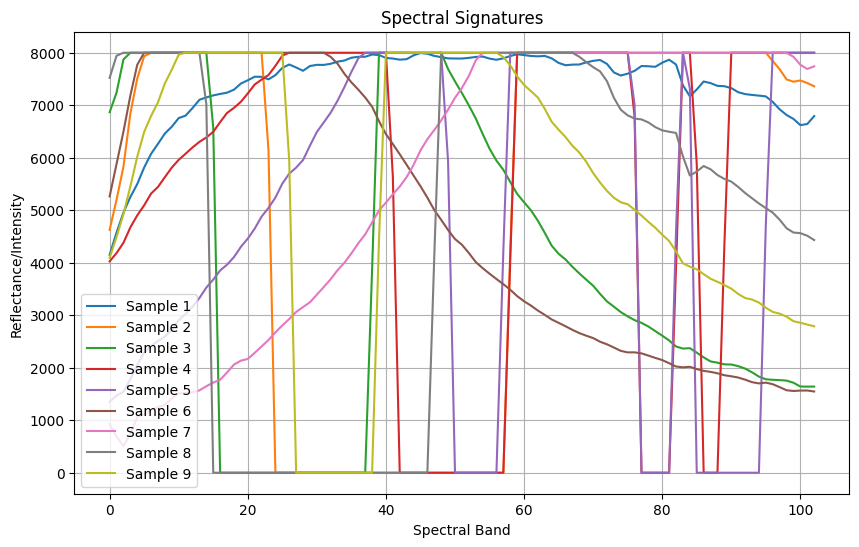

In [52]:
A_matrixSNPA_PU_path = '../matrices A extracted with SNPA/'
A_matrixSNPA_PU_information = sio.loadmat(os.path.join(A_matrixSNPA_PU_path, 'result_snpa_pavia.mat'))['Apu']

import numpy as np
import matplotlib.pyplot as plt


# Transposing the matrix to plot spectral signatures
A_transposed = A_matrixSNPA_PU_information.T

# Plotting spectral signatures
plt.figure(figsize=(10, 6))
for i in range(len(A_transposed)):
    plt.plot(A_transposed[i], label=f'Sample {i+1}')

plt.title('Spectral Signatures')
plt.xlabel('Spectral Band')
plt.ylabel('Reflectance/Intensity')
plt.legend()
plt.grid(True)
plt.show()


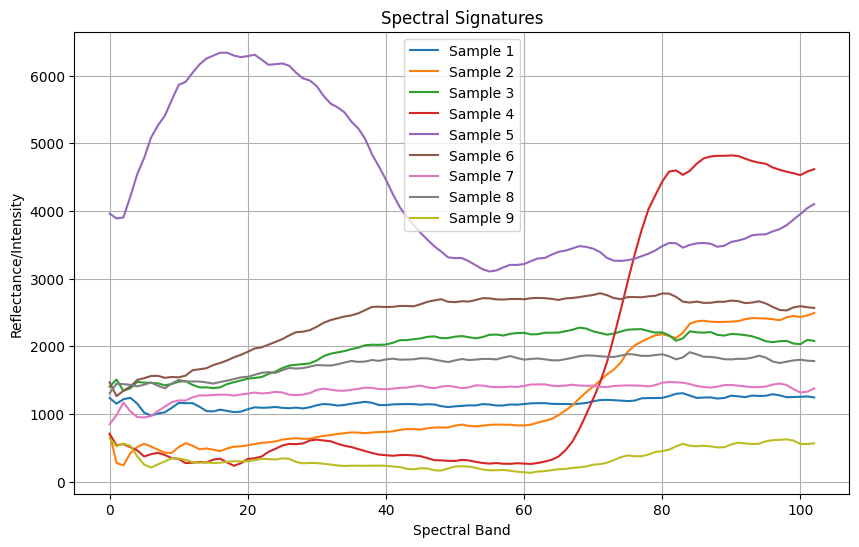

In [53]:
import numpy as np
import matplotlib.pyplot as plt


# Transposing the matrix to plot spectral signatures
A_transposed = A_matrixPU_information.T

# Plotting spectral signatures
plt.figure(figsize=(10, 6))
for i in range(len(A_transposed)):
    plt.plot(A_transposed[i], label=f'Sample {i+1}')

plt.title('Spectral Signatures')
plt.xlabel('Spectral Band')
plt.ylabel('Reflectance/Intensity')
plt.legend()
plt.grid(True)
plt.show()


# SNPA abundances and reconstruction

In [54]:
import numpy as np
from scipy.optimize import lsq_linear

# Reshape HSI image to 2D array
num_pixels = original_X.shape[0] * original_X.shape[1]
num_bands = original_X.shape[2]
hsi_2d = original_X.reshape(num_pixels, num_bands)

# Print shapes for debugging
print("Original X shape:", original_X.shape)
print("Calculated number of pixels:", num_pixels)

# Perform least squares regression for each pixel
abundancesSNPA_PU = []
for pixel_spectrum in hsi_2d:
    result = lsq_linear(A_matrixSNPA_PU_information, pixel_spectrum, bounds=(0, np.inf), method='trf')
    x = result.x
    abundancesSNPA_PU.append(x)

# Reshape abundances back to original image shape
#abundances_image = np.array(abundances).reshape(original_X.shape[:-1])

# 'abundances_image' now contains the abundance maps for each pure pixel in the HSI imag
abundancesSNPA_PU
abundancesSNPA_PU=np.array(abundancesSNPA_PU)
abundancesSNPA_PU_image = np.array(abundancesSNPA_PU).reshape(original_X.shape[:-1] + (-1,))

Original X shape: (610, 340, 103)
Calculated number of pixels: 207400


In [55]:
abundancesSNPA_PU_image.shape

(610, 340, 9)

In [54]:
import pickle

# Assuming abundancesSNPA_PU and abundancesSNPA_PU_image are already defined

# Saving abundancesSNPA_PU
#with open('abundancesSNPA_PU.pickle', 'wb') as f:
#    pickle.dump(abundancesSNPA_PU, f)

# Saving abundancesSNPA_PU_image
#with open('abundancesSNPA_PU_image.pickle', 'wb') as f:
#    pickle.dump(abundancesSNPA_PU_image, f)


# Reading abundancesSNPA_PU
with open('abundancesSNPA_PU.pickle', 'rb') as f:
    abundancesSNPA_PU = pickle.load(f)

# Reading abundancesSNPA_PU_image
with open('abundancesSNPA_PU_image.pickle', 'rb') as f:
    abundancesSNPA_PU_image = pickle.load(f)



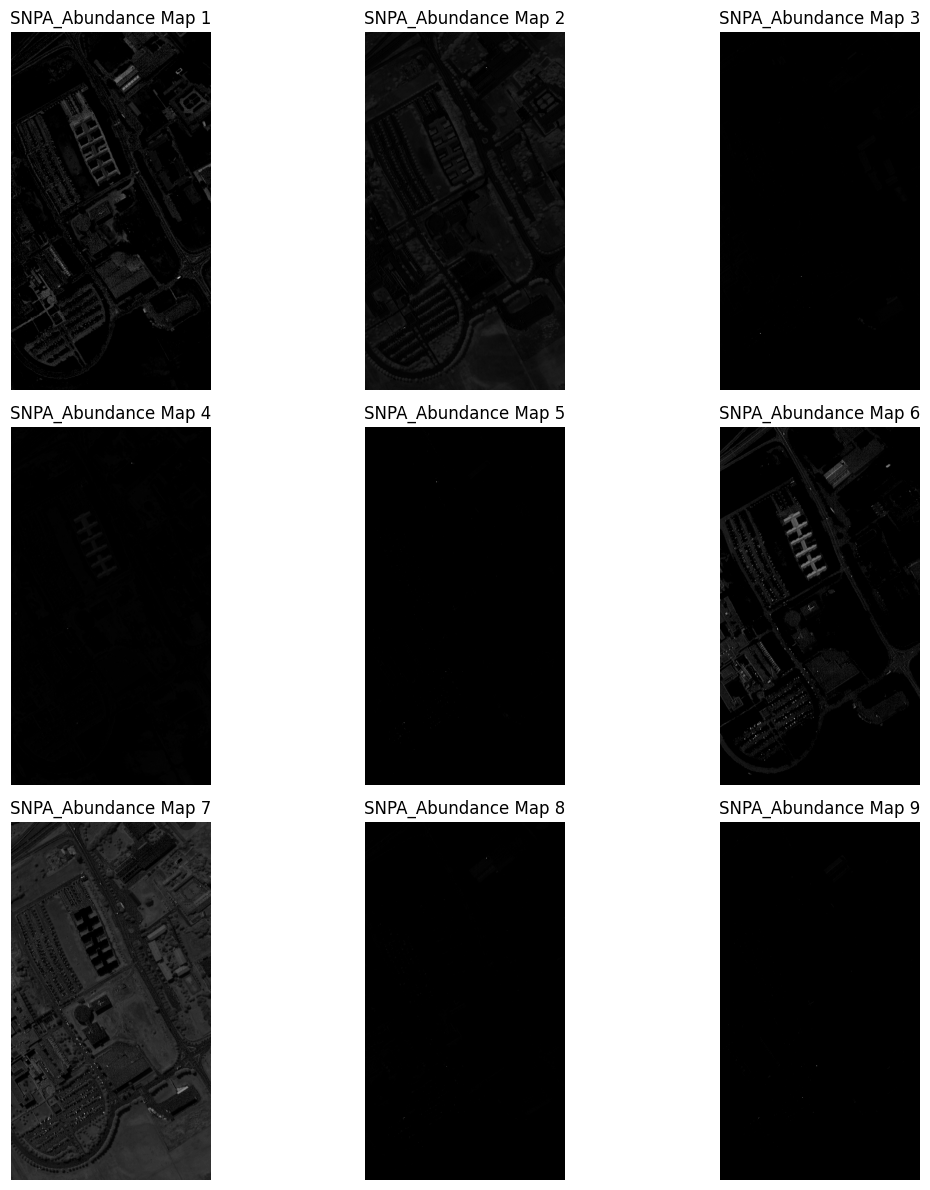

In [55]:
import matplotlib.pyplot as plt

# Define the number of rows and columns for the grid
num_rows = 3
num_cols = 3

# Create a new figure and axis objects
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Plot each abundance map in the grid
for i, ax in enumerate(axes.flat):
    ax.imshow(abundancesSNPA_PU_image[:,:,i], cmap='gray')
    ax.set_title(f'SNPA_Abundance Map {i+1}')
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [71]:
# Reconstruct the image using abundances
reconstructed_imageSNPA_PU = np.empty((abundancesSNPA_PU.shape[0],0))

# Iterate through each abundance map and multiply by the corresponding endmember spectrum
for i in range(9):
    abundance_mapSNPA_PU= abundancesSNPA_PU[:,i].reshape(-1,1)
    endmember_spectrum = A_matrixSNPA_PU_information[i, :].reshape(1,-1)

    # Perform matrix multiplication
    channel_reconstruction= np.dot(abundance_mapSNPA_PU, endmember_spectrum)

    # Concatenate the channel reconstruction to the reconstructed image array along axis 1
    reconstructed_imageSNPA_PU = np.concatenate((reconstructed_imageSNPA_PU, channel_reconstruction), axis=1)





In [72]:
reconstructed_imageSNPA_PU.shape

(207400, 81)

In [73]:
K = 30 if dataset == 'IP' else 15
reconstructed_imageSNPA_PU_reshaped=reconstructed_imageSNPA_PU.reshape((610,340,81))
reconstructed_imageSNPA_PU_reshaped,pca = applyPCA(reconstructed_imageSNPA_PU_reshaped,numComponents=K)

reconstructed_imageSNPA_PU_reshaped.shape

(610, 340, 15)

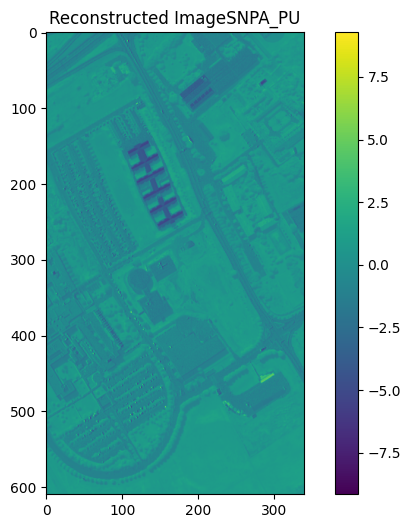

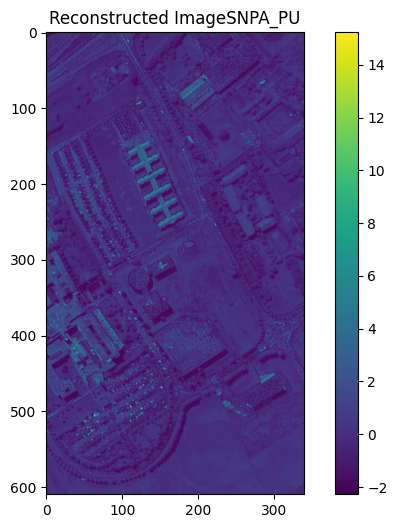

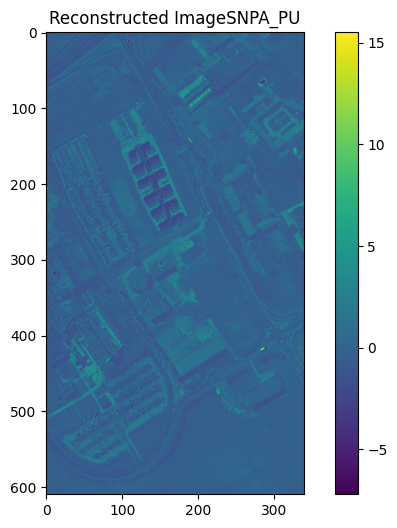

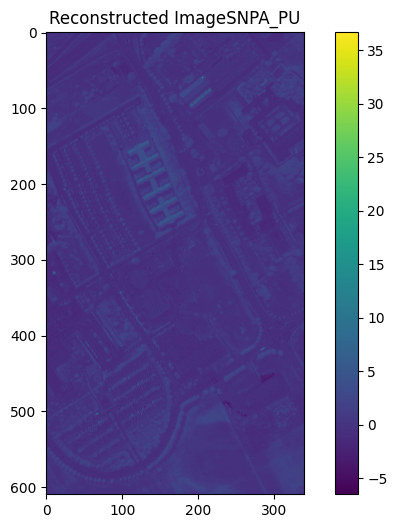

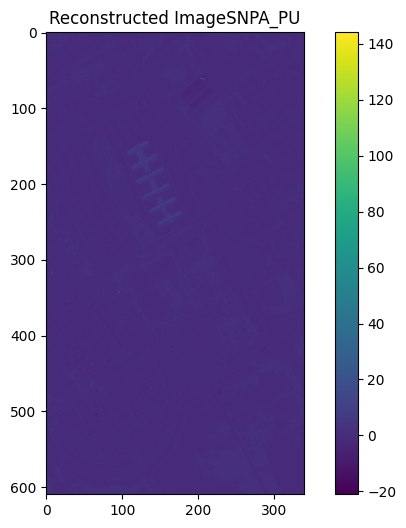

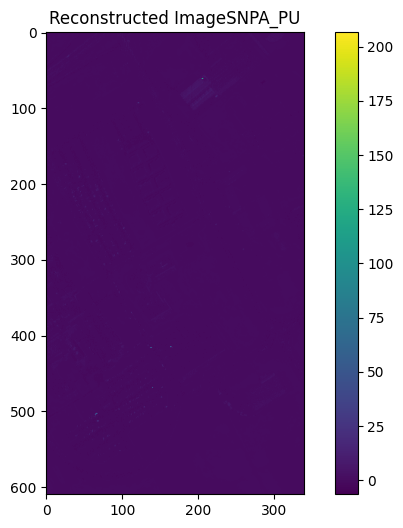

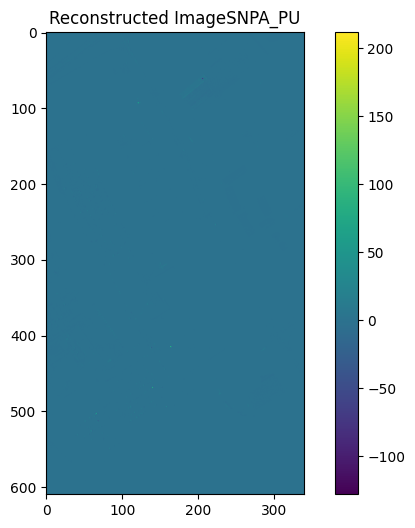

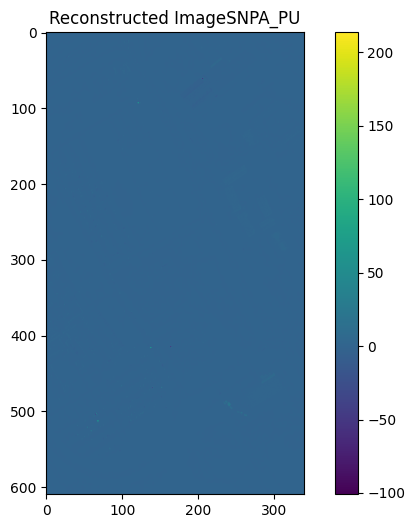

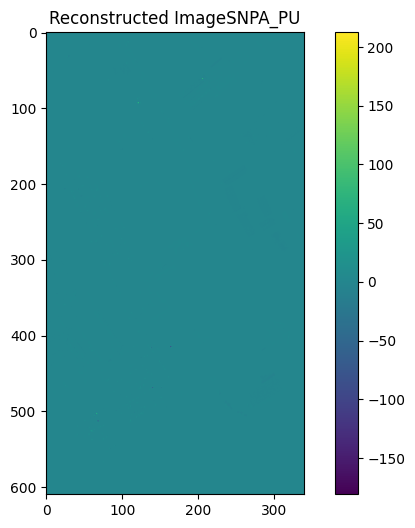

In [74]:

import numpy as np

for i in range (9):
    # Plot the reconstructed image
    plt.figure(figsize=(8, 6))
    plt.imshow(reconstructed_imageSNPA_PU_reshaped[:,:,i])
    plt.title('Reconstructed ImageSNPA_PU')
    plt.colorbar()
    plt.show()


In [75]:
reconstructed_imageSNPA_PU_reshaped.shape

(610, 340, 15)

In [76]:
# Saving reconstructed_imageSNPA_PU
with open('reconstructed_imageSNPA_PU_reshaped.pickle', 'wb') as f:
    pickle.dump(reconstructed_imageSNPA_PU_reshaped, f)

with open('reconstructed_imageSNPA_PU_reshaped.pickle', 'rb') as f:
    reconstructed_imageSNPA_PU_reshaped = pickle.load(f)

# My abundances and reconstruction

In [51]:
import numpy as np
from scipy.optimize import lsq_linear

# Reshape HSI image to 2D array
num_pixels = original_X.shape[0] * original_X.shape[1]
num_bands = original_X.shape[2]
hsi_2d = original_X.reshape(num_pixels, num_bands)

# Print shapes for debugging
print("Original X shape:", original_X.shape)
print("Calculated number of pixels:", num_pixels)

# Perform least squares regression for each pixel
abundancesPU = []
for pixel_spectrum in hsi_2d:
    result = lsq_linear(A_matrixPU_information,
                        pixel_spectrum, bounds=(0, np.inf), method='trf')
    x = result.x
    abundancesPU.append(x)

# Reshape abundances back to original image shape
#abundances_image = np.array(abundances).reshape(original_X.shape[:-1])

# 'abundances_image' now contains the abundance maps for each pure pixel in the HSI imag
abundancesPU
abundancesPU=np.array(abundancesPU)
abundances_imagePU = np.array(abundancesPU).reshape(original_X.shape[:-1] + (-1,))

Original X shape: (610, 340, 103)
Calculated number of pixels: 207400


In [70]:
abundances_imagePU.shape



(610, 340, 9)

In [57]:
import pickle

# Assuming abundancesSNPA_PU and abundancesSNPA_PU_image are already defined

# Saving abundancesSNPA_PU
#with open('abundancesPU.pickle', 'wb') as f:
#    pickle.dump(abundancesPU, f)

# Saving abundancesSNPA_PU_image
#with open('abundances_imagePU.pickle', 'wb') as f:
#    pickle.dump(abundances_imagePU, f)



# Reading abundancesSNPA_PU
with open('abundancesPU.pickle', 'rb') as f:
    abundancesPU = pickle.load(f)

# Reading abundancesSNPA_PU_image
with open('abundances_imagePU.pickle', 'rb') as f:
    abundances_imagePU = pickle.load(f)


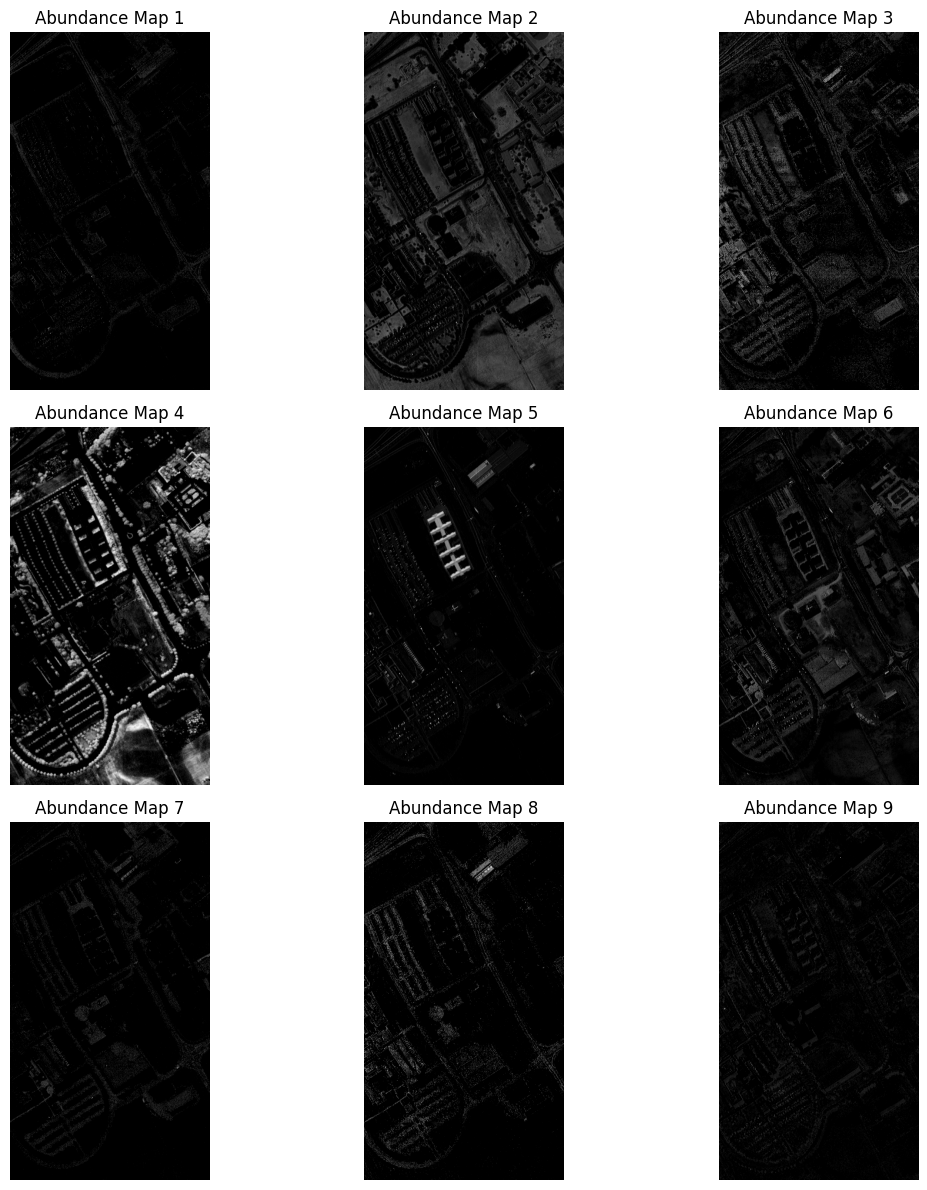

In [58]:
import matplotlib.pyplot as plt

# Define the number of rows and columns for the grid
num_rows = 3
num_cols = 3

# Create a new figure and axis objects
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Plot each abundance map in the grid
for i, ax in enumerate(axes.flat):
    ax.imshow(abundances_imagePU[:,:,i], cmap='gray')
    ax.set_title(f'Abundance Map {i+1}')
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [109]:
A_matrixPU_information[1, :]

array([1151,  274, 1507,  535, 3888, 1262,  980, 1446,  520], dtype=uint16)

In [59]:
import numpy as np

# Initialize the empty array to hold the reconstructed image
reconstructed_imagePU = np.empty((abundancesPU.shape[0], 0))

# Iterate through each abundance map and multiply by the corresponding endmember spectrum
for i in range(9):
    abundance_mapPU = abundancesPU[:, i].reshape(-1, 1)
    endmember_spectrum = A_matrixPU_information[i, :].reshape(1, -1)

    # Perform matrix multiplication
    channel_reconstruction = np.dot(abundance_mapPU, endmember_spectrum)

    # Concatenate the channel reconstruction to the reconstructed image array along axis 1
    reconstructed_imagePU = np.concatenate((reconstructed_imagePU, channel_reconstruction), axis=1)





In [60]:
reconstructed_imagePU.shape

(207400, 81)

In [63]:
K = 30 if dataset == 'IP' else 15
reconstructed_imagePU_reshaped=reconstructed_imagePU.reshape((610,340,81))
reconstructed_imagePU_reshaped,pca = applyPCA(reconstructed_imagePU_reshaped,numComponents=K)

reconstructed_imagePU_reshaped.shape

(610, 340, 15)

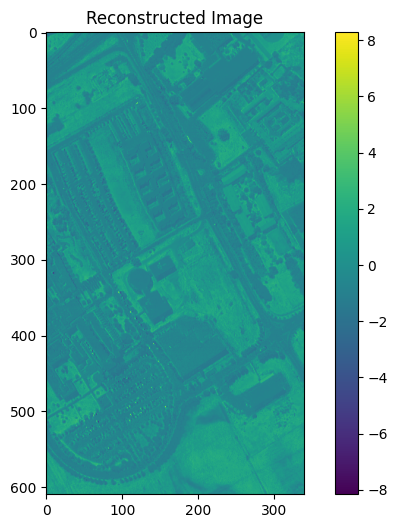

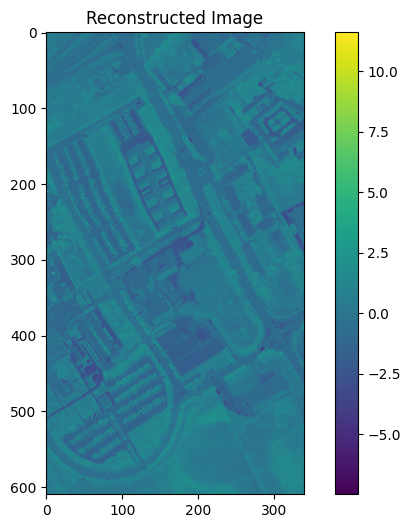

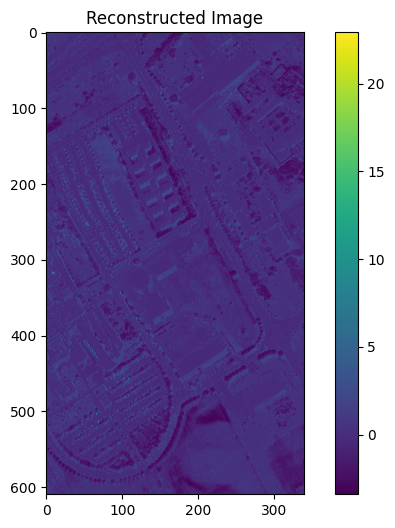

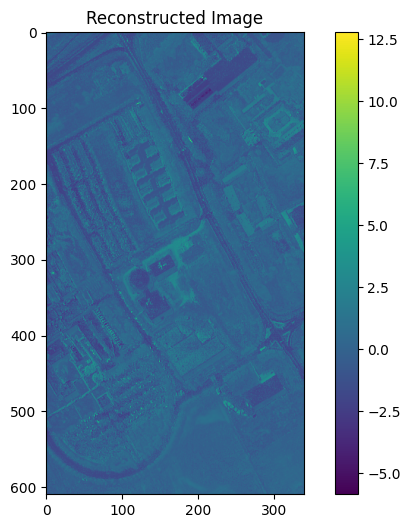

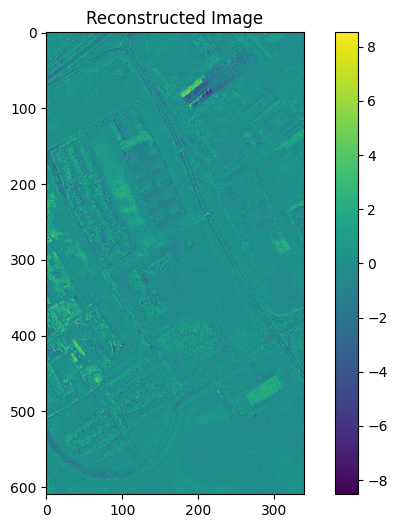

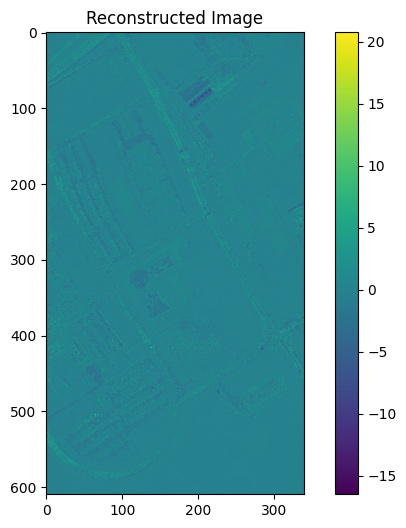

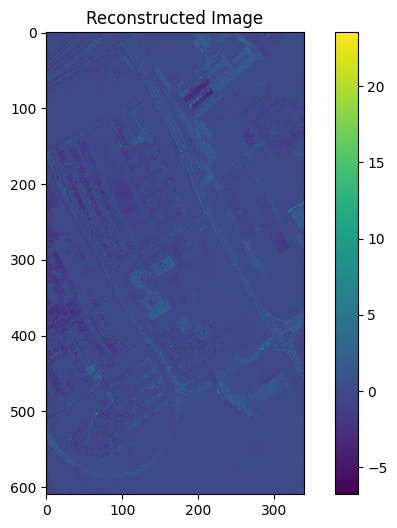

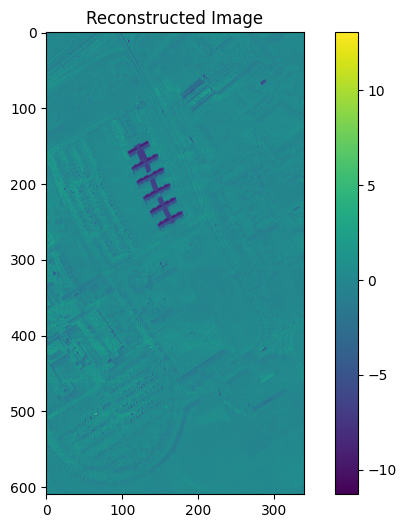

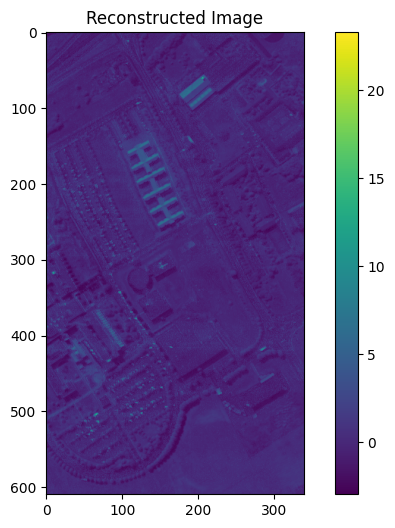

In [64]:

import numpy as np

for i in range (9):
    # Plot the reconstructed image
    plt.figure(figsize=(8, 6))
    plt.imshow(reconstructed_imagePU_reshaped[:,:,i])
    plt.title('Reconstructed Image')
    plt.colorbar()
    plt.show()


In [81]:
reconstructed_imagePU_reshaped.shape


(610, 340, 15)

In [65]:
# Saving reconstructed_imageSNPA_PU
#with open('reconstructed_imagePU_reshaped.pickle', 'wb') as f:
#    pickle.dump(reconstructed_imagePU_reshaped, f)

with open('reconstructed_imagePU_reshaped.pickle', 'rb') as f:
    reconstructed_imagePU_reshaped = pickle.load(f)

In [69]:
K = 30 if dataset == 'IP' else 15
original_X_PCA,pca = applyPCA(original_X,numComponents=K)

original_X_PCA.shape

(610, 340, 15)

In [70]:
#with open('original_X_PCA.pickle', 'wb') as f:
#    pickle.dump(original_X_PCA, f)

with open('original_X_PCA.pickle', 'rb') as f:
    original_X_PCA = pickle.load(f)

# Relative reconstruction error

In [83]:
import numpy as np

def relative_reconstruction_error(original_image, reconstructed_image):
    """
    Calculate the relative reconstruction error between the original and reconstructed images.
    """
    # Convert images to float to avoid integer division
    original_image = np.asarray(original_image, dtype=np.float64)
    reconstructed_image = np.asarray(reconstructed_image, dtype=np.float64)
    
    # Avoid division by zero by adding a small constant
    epsilon = 1e-10
    
    # Calculate the relative error
    relative_error = np.abs(original_image - reconstructed_image) / (np.abs(original_image) + epsilon)
    
    # Calculate the mean relative error
    mean_relative_error = np.mean(relative_error)
    
    return mean_relative_error


# Calculate relative reconstruction errors
error1 = relative_reconstruction_error(original_X_PCA, reconstructed_imagePU_reshaped)
error2 = relative_reconstruction_error(original_X_PCA, reconstructed_imageSNPA_PU_reshaped)


print(f"Relative reconstruction error for PU: {error1}")
print(f"Relative reconstruction error for SNPA_PU: {error2}")

# Compare the errors
if error1 < error2:
    print("Reconstructed image PU has lower relative error.")
elif error1 > error2:
    print("Reconstructed image SNPA_PU has lower relative error.")
else:
    print("Both reconstructed images have the same relative error.")


Relative reconstruction error for PU: 24.6420347851767
Relative reconstruction error for SNPA_PU: 13.43915600510205
Reconstructed image SNPA_PU has lower relative error.


/home/ubuntu/.local/lib/python3.10/site-packages/spectral/graphics/spypylab.py:796: UserWarning:

Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.



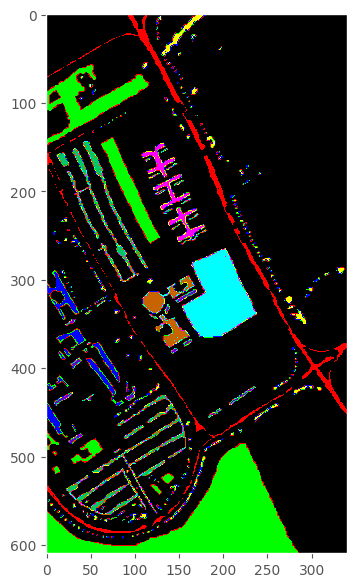

In [50]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

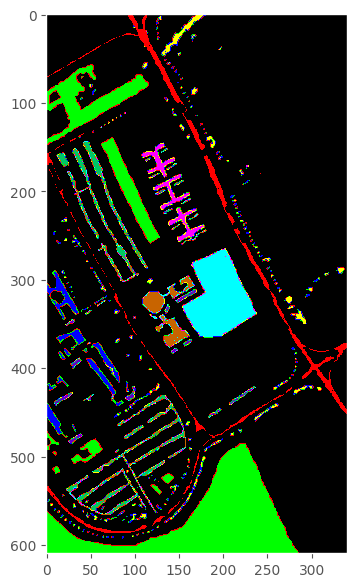

In [51]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))


In [52]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

<Figure size 640x480 with 0 Axes>

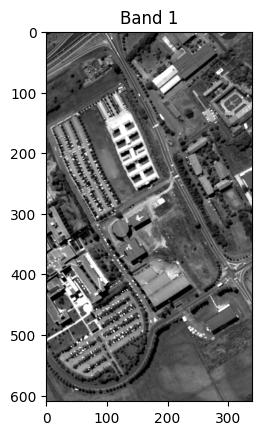

<Figure size 640x480 with 0 Axes>

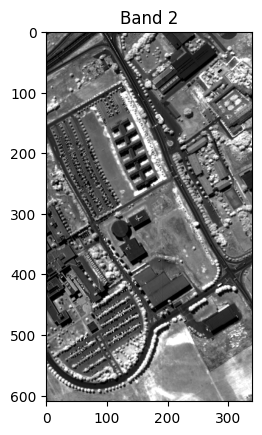

<Figure size 640x480 with 0 Axes>

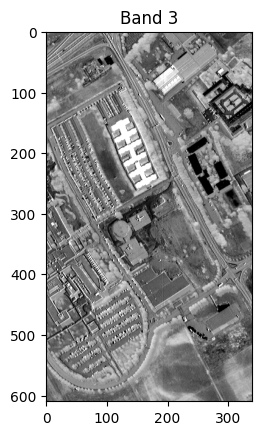

<Figure size 640x480 with 0 Axes>

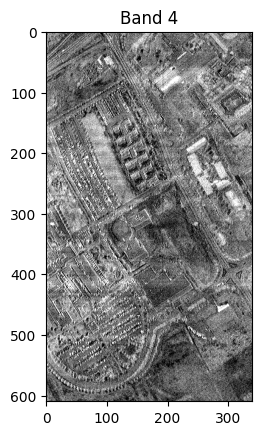

<Figure size 640x480 with 0 Axes>

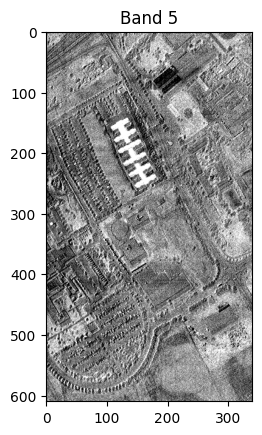

<Figure size 640x480 with 0 Axes>

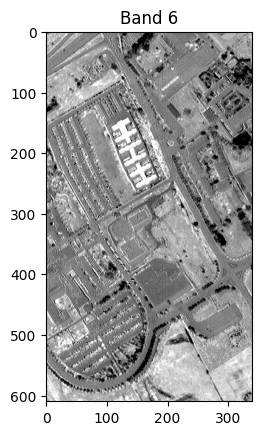

<Figure size 640x480 with 0 Axes>

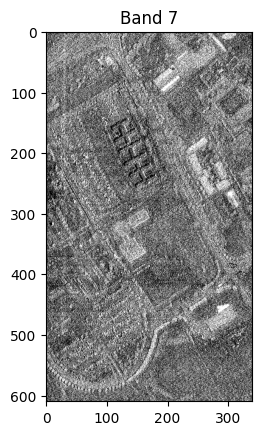

<Figure size 640x480 with 0 Axes>

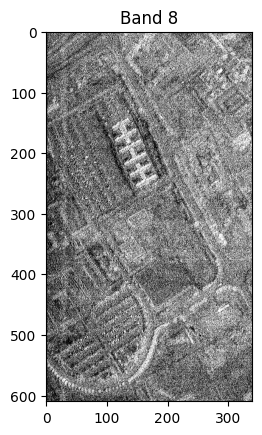

<Figure size 640x480 with 0 Axes>

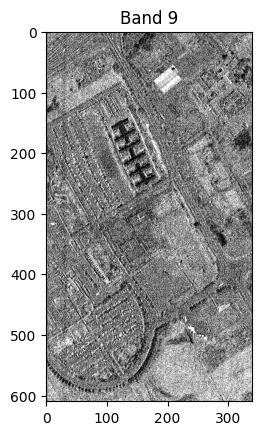

<Figure size 640x480 with 0 Axes>

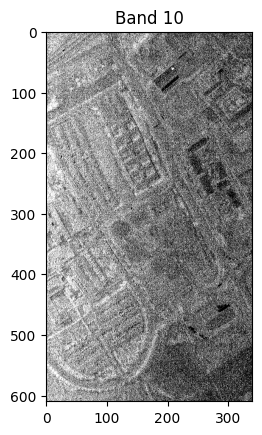

<Figure size 640x480 with 0 Axes>

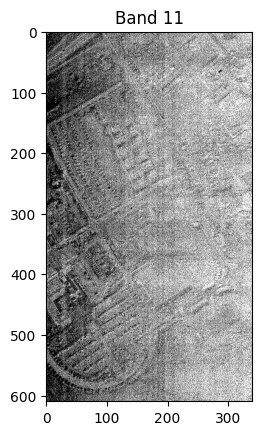

<Figure size 640x480 with 0 Axes>

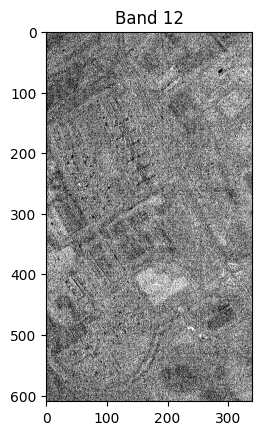

<Figure size 640x480 with 0 Axes>

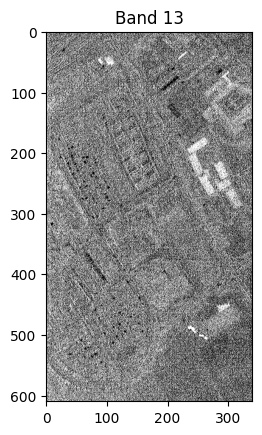

<Figure size 640x480 with 0 Axes>

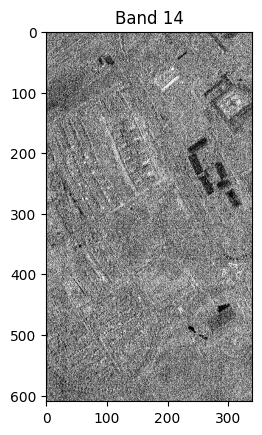

<Figure size 640x480 with 0 Axes>

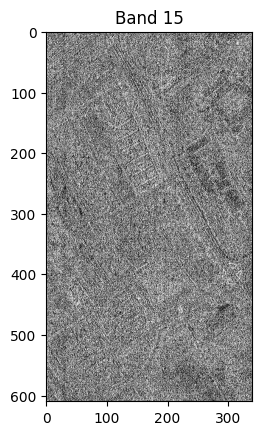

In [30]:
import spectral
import matplotlib.pyplot as plt


# Assuming your image has a shape of (610, 340, 15)
image_shape = X.shape

# Loop through each band and display it
for band_index in range(image_shape[2]):
    # Extract the band
    band = X[:,:,band_index]

    # Display the band
    plt.figure()
    spectral.imshow(band, stretch=(0.02, 0.98), title=f"Band {band_index+1}")
    plt.show()


spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)